<a href="https://colab.research.google.com/github/DragonBGW/PolygonColorizer-UNet/blob/main/training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install torch torchvision wandb matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import drive
drive.mount('/content/drive')
## downloading dataset from google drive

Mounted at /content/drive


In [4]:
!gdown --id 1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM --output dataset.zip
!unzip -q dataset.zip -d data


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM
To: /content/dataset.zip
100% 57.8k/57.8k [00:00<00:00, 96.1MB/s]


In [5]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: basuchandril402 (basuchandril402-jadavpur-university-press) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [52]:
wandb.init(
    project="ayna-unet-colorizer",  # or any unique project name
    name="unet-l1loss-100epochs",   # custom run name
    config={
        "epochs": 100,
        "batch_size": 8,
        "learning_rate": 1e-3,
        "loss": "L1 + 0.2*CrossEntropy",
        "conditioning": "OuterProduct (Conv)",
        "model": "UNet",
        "image_size": 128,
        "color_map_dim": 10
    }
)


Define Dataset Class (Polygon Dataset Class)

In [15]:
color_map = {
    "red": 0,
    "blue": 1,
    "green": 2,
    "yellow": 3,
    "black": 4,
    "white": 5,
    "cyan": 6,
    "magenta": 7,
    "orange": 8,
    "purple": 9,
}


In [17]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import torchvision.transforms as T

class PolygonColorDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None, color_map=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.dir = data_dir
        self.transform = transform
        self.color_map = color_map or {
            "red": 0, "blue": 1, "green": 2, "yellow": 3,
            "black": 4, "white": 5, "cyan": 6, "magenta": 7,
            "orange": 8, "purple": 9
        }
        self.colors = list(self.color_map.keys())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_path = os.path.join(self.dir, "inputs", item["input_polygon"])
        output_path = os.path.join(self.dir, "outputs", item["output_image"])
        color = item["colour"]  # UK spelling!

        x = Image.open(input_path).convert("L")     # Grayscale input
        y = Image.open(output_path).convert("RGB")  # Colored output

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        color_tensor = torch.zeros(len(self.color_map))
        color_tensor[self.color_map[color]] = 1.0

        return (x, color_tensor), y



Load Dataset & Show a Sample


In [18]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define color map (should match the dataset)
color_map = {
    "red": 0, "blue": 1, "green": 2, "yellow": 3,
    "black": 4, "white": 5, "cyan": 6, "magenta": 7,
    "orange": 8, "purple": 9
}

# Define image transformation (resize + tensor conversion)
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

# Create dataset and dataloader
train_ds = PolygonColorDataset(
    data_dir="data/dataset/training",
    json_file="data/dataset/training/data.json",
    transform=transform,
    color_map=color_map
)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)


In [14]:
import json

with open("data/dataset/training/data.json", "r") as f:
    data = json.load(f)

print("Number of items:", len(data))
print("First item:", data[0])


Number of items: 56
First item: {'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


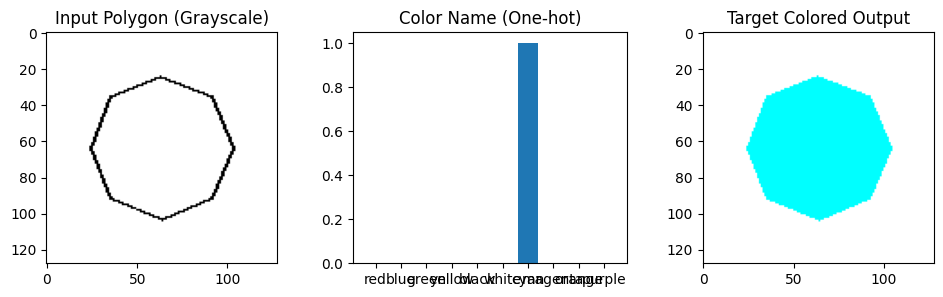

In [19]:
# Visualize one sample
(x, color), y = train_ds[0]

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(x.squeeze(), cmap='gray')
plt.title("Input Polygon (Grayscale)")

plt.subplot(1, 3, 2)
plt.bar(train_ds.colors, color.numpy())
plt.title("Color Name (One-hot)")

plt.subplot(1, 3, 3)
plt.imshow(y.permute(1, 2, 0))
plt.title("Target Colored Output")

plt.show()


Implementing UNet in PyTorch


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=3, cond_dim=10):  # cond_dim = len(color_map)
        super(UNet, self).__init__()
        self.cond_dim = cond_dim
        self.in_channels = in_channels

        # Conditioning layers (outer product trick)
        self.cond_to_map = nn.Sequential(
            nn.Linear(cond_dim, 128),
            nn.ReLU(),
        )

        # Encoder
        self.enc1 = ConvBlock(in_channels + 1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        self.color_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),      # Global pooling
            nn.Flatten(),                      # (B, 1024)
            nn.Linear(1024, cond_dim)          # Predict one of 10 colors
        )

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x, cond):  # x: (B,1,128,128), cond: (B,10)
        B, _, H, W = x.shape

        # Conditioning map from outer product of learned projections
        h_embed = self.cond_to_map(cond).unsqueeze(2)  # (B, 128, 1)
        w_embed = self.cond_to_map(cond).unsqueeze(1)  # (B, 1, 128)
        cond_map = torch.bmm(h_embed, w_embed)         # (B, 128, 128)
        cond_map = cond_map.unsqueeze(1)               # (B, 1, 128, 128)

        # Concatenate with image input
        x = torch.cat([x, cond_map], dim=1)  # (B, 2, 128, 128)

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.final_conv(d1)
        out = torch.sigmoid(out)  # normalize to [0, 1]
        # Predict color class from bottleneck
        color_pred = self.color_classifier(b)
        return out, color_pred



Training Loop with wandb Logging

In [57]:
import torch.optim as optim
import wandb

# Login to wandb
wandb.login()

# Initialize wandb project
wandb.init(
    project="ayna-unet-colorization",
    name="unet-l1loss-100epochs",
    config={
        "epochs": 100,
        "batch_size": 8,
        "learning_rate": 1e-3,
        "loss": "L1 + 0.2*CrossEntropy",
        "conditioning": "OuterProduct (Conv)",
        "model": "UNet",
        "image_size": 128,
        "color_map_dim": len(color_map)
    }
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model, optimizer, loss
model = UNet(in_channels=1, n_classes=3, cond_dim=len(color_map)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()
class_loss_fn = nn.CrossEntropyLoss()

# Dataloader again (in case rerun)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

# Training loop
epochs = 100
λ = 0.2  # weighting for auxiliary loss

for epoch in range(epochs):
    model.train()
    epoch_total_loss = 0
    epoch_image_loss = 0
    epoch_color_loss = 0

    for batch in train_dl:
        (x, color), y = batch
        x, color, y = x.to(device), color.to(device), y.to(device)

        optimizer.zero_grad()
        output, color_pred = model(x, color)

        image_loss = criterion(output, y)
        target_class = torch.argmax(color, dim=1)
        color_loss = class_loss_fn(color_pred, target_class)

        loss = image_loss + λ * color_loss
        loss.backward()
        optimizer.step()

        epoch_total_loss += loss.item()
        epoch_image_loss += image_loss.item()
        epoch_color_loss += color_loss.item()

    avg_total = epoch_total_loss / len(train_dl)
    avg_image = epoch_image_loss / len(train_dl)
    avg_color = epoch_color_loss / len(train_dl)

    # Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "total_loss": avg_total,
        "image_loss": avg_image,
        "color_loss": avg_color
    })

    print(f"Epoch {epoch+1}/{epochs} - Total Loss: {avg_total:.4f} | Image: {avg_image:.4f} | Color: {avg_color:.4f}")

    # 📸 Log a prediction sample every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        (sample_x, sample_color), sample_y = next(iter(train_dl))
        sample_x = sample_x.to(device)
        sample_color = sample_color.to(device)
        sample_y = sample_y.to(device)

        with torch.no_grad():
            sample_pred, sample_logits = model(sample_x, sample_color)

        # Log first item
        input_img = sample_x[0].squeeze().cpu().numpy()
        pred_img = sample_pred[0].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        true_img = sample_y[0].permute(1, 2, 0).cpu().numpy()

        pred_class = torch.argmax(sample_logits[0]).item()
        pred_color = list(color_map.keys())[list(color_map.values()).index(pred_class)]

        wandb.log({
            f"Sample Input (Epoch {epoch+1})": wandb.Image(input_img, caption="Input Polygon"),
            f"Model Output (Pred: {pred_color})": wandb.Image(pred_img, caption="Model Output"),
            f"Ground Truth": wandb.Image(true_img, caption="Target Image")
        })


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


color_loss,████▅▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
image_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▇▇▇▆▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
color_loss,0.00366
epoch,100
image_loss,0.03662
total_loss,0.03736


Using device: cuda
Epoch 1/100 - Total Loss: 0.9710 | Image: 0.4493 | Color: 2.6089
Epoch 2/100 - Total Loss: 0.8255 | Image: 0.3788 | Color: 2.2332
Epoch 3/100 - Total Loss: 0.7795 | Image: 0.3398 | Color: 2.1986
Epoch 4/100 - Total Loss: 0.7354 | Image: 0.3105 | Color: 2.1242
Epoch 5/100 - Total Loss: 0.7071 | Image: 0.2831 | Color: 2.1197
Epoch 6/100 - Total Loss: 0.6765 | Image: 0.2565 | Color: 2.1001
Epoch 7/100 - Total Loss: 0.6535 | Image: 0.2311 | Color: 2.1124
Epoch 8/100 - Total Loss: 0.6341 | Image: 0.2068 | Color: 2.1362
Epoch 9/100 - Total Loss: 0.6002 | Image: 0.1863 | Color: 2.0695
Epoch 10/100 - Total Loss: 0.5789 | Image: 0.1723 | Color: 2.0327
Epoch 11/100 - Total Loss: 0.4809 | Image: 0.1598 | Color: 1.6052
Epoch 12/100 - Total Loss: 0.4300 | Image: 0.1495 | Color: 1.4025
Epoch 13/100 - Total Loss: 0.4117 | Image: 0.1384 | Color: 1.3663
Epoch 14/100 - Total Loss: 0.3284 | Image: 0.1320 | Color: 0.9822
Epoch 15/100 - Total Loss: 0.2765 | Image: 0.1246 | Color: 0.7593


Inference Code Cell


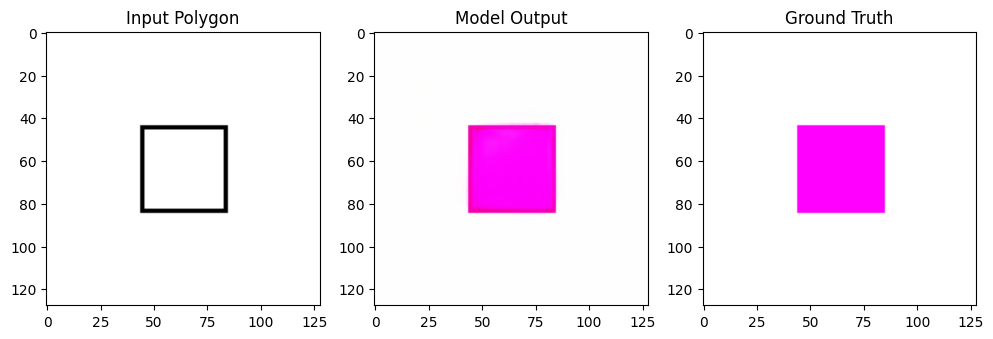

In [58]:
# Load the trained model
model.eval()  # set to evaluation mode

# Sample from validation set (or use training if val not defined yet)
sample_idx = 3  # pick any index
(x, color), y_true = train_ds[sample_idx]

# Add batch dimension and move to device
x = x.unsqueeze(0).to(device)          # shape: (1, 1, 128, 128)
color = color.unsqueeze(0).to(device)  # shape: (1, cond_dim)

# Run inference
with torch.no_grad():
    y_pred, _ = model(x, color)
  # shape: (1, 3, 128, 128)

# Move tensors to CPU and convert for display
x_np = x.squeeze().cpu().numpy()
y_pred_np = y_pred.squeeze().permute(1, 2, 0).cpu().numpy()
y_true_np = y_true.permute(1, 2, 0).cpu().numpy()

# Clamp predicted image to [0,1]
y_pred_np = y_pred_np.clip(0, 1)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(x_np, cmap='gray')
plt.title("Input Polygon")

plt.subplot(1, 3, 2)
plt.imshow(y_pred_np)
plt.title("Model Output")

plt.subplot(1, 3, 3)
plt.imshow(y_true_np)
plt.title("Ground Truth")

plt.show()
